In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
import re

from tabulate import tabulate
from collections import Counter

from imblearn.over_sampling import SMOTE

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from scipy import stats
from scipy.stats import kurtosis, skew
from scipy.stats.mstats import winsorize

from xgboost import XGBClassifier

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.utils import resample
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, auc

In [2]:
# Load the dataset
df_cleaned = pd.read_excel("df_cleaned.xlsx")

In [3]:
from matplotlib.colors import ListedColormap
colors = ['#d73027', '#fee08b', '#4575b4']  # Red, Yellow, Blue
cmap = ListedColormap(colors)

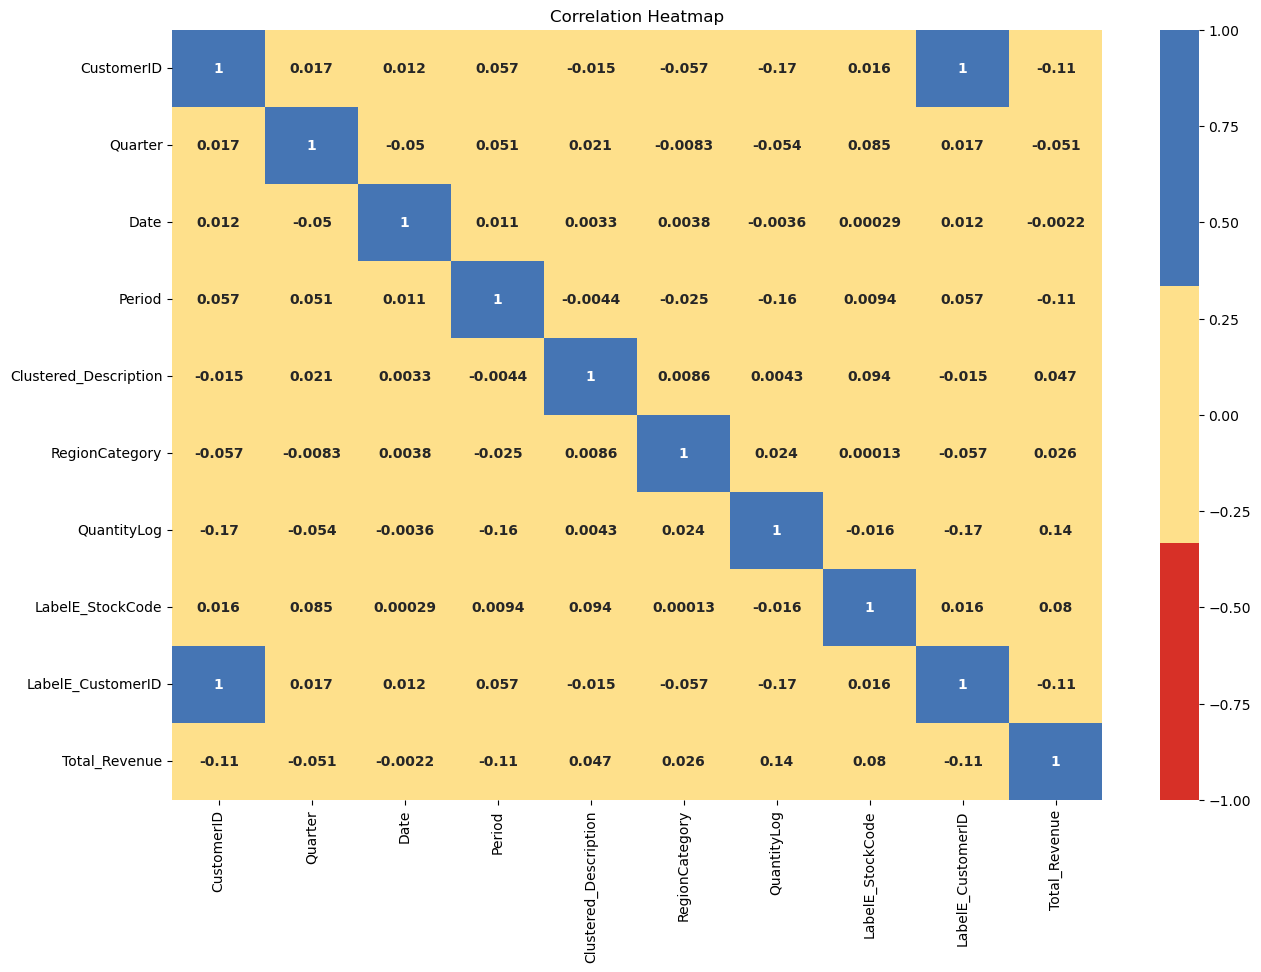

In [4]:
# Correlation only on features (Feature-to-Feature)
feature = 'Is_UK'
F2F = df_cleaned.drop(columns=[feature], axis=1)
correlation_matrix = F2F.corr()

# Plotting the correlation heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap=cmap, 
            vmin=-1, vmax=1, annot_kws={'fontweight':'bold'})
plt.title('Correlation Heatmap')
plt.show()

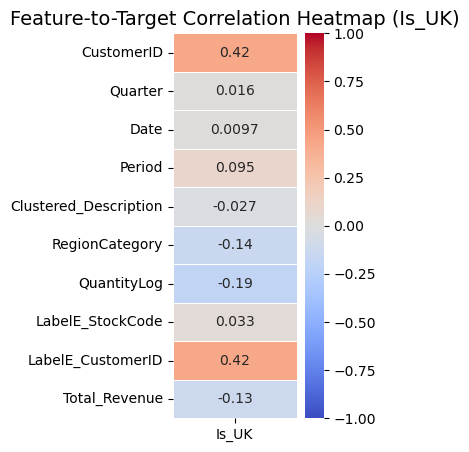

In [5]:
# Define target variable
target = 'Is_UK'

# Compute correlation of each feature with the target
F2T = df_cleaned.corr()[[target]].drop(target)  # Convert to DataFrame

# Plot heatmap
plt.figure(figsize=(2, 5))
sns.heatmap(F2T, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)

# Title
plt.title(f'Feature-to-Target Correlation Heatmap ({target})', fontsize=14)

plt.show()

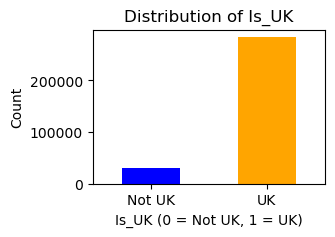

In [6]:
# Plot bar chart for Is_UK
plt.figure(figsize=(3, 2))
df_cleaned["Is_UK"].value_counts().sort_index().plot(kind="bar", color=["blue", "orange"])
plt.xlabel("Is_UK (0 = Not UK, 1 = UK)")
plt.ylabel("Count")
plt.title("Distribution of Is_UK")
plt.xticks(ticks=[0, 1], labels=["Not UK", "UK"], rotation=0)
plt.show()

In [7]:
print(df_cleaned["Is_UK"].value_counts())

Is_UK
1    284037
0     30625
Name: count, dtype: int64


# Data Sampling

In [8]:
# Separate UK data and other countries
df_uk = df_cleaned[df_cleaned["Is_UK"] == 1]
df_other = df_cleaned[df_cleaned["Is_UK"] != 1]
n_samples = int(len(df_other) * 0.3)

print(f"Total UK samples: {len(df_uk)}")
print(f"Total Non-UK samples: {len(df_other)}")
print(f"Desired samples: {n_samples}")

Total UK samples: 284037
Total Non-UK samples: 30625
Desired samples: 9187


In [9]:
df_uk_downsampled = resample(df_uk, 
                             replace=True,  
                             n_samples=n_samples,  
                             random_state=42)

df_other_upsampled = resample(df_other,  
                              replace=True,  
                              n_samples=int(len(df_uk_downsampled) * 1.00),
                              random_state=42)

df_balanced_uk = pd.concat([df_uk_downsampled, df_other_upsampled])
print(df_balanced_uk["Is_UK"].value_counts(normalize=True) * 100)

Is_UK
1    50.0
0    50.0
Name: proportion, dtype: float64


In [10]:
# Separate UK data and other countries
df_uk_b = df_balanced_uk[df_balanced_uk["Is_UK"] == 1]
df_other_b = df_balanced_uk[df_balanced_uk["Is_UK"] != 1]

print(f"Total UK samples: {len(df_uk_b)}")
print(f"Total Non-UK samples: {len(df_other_b)}")

Total UK samples: 9187
Total Non-UK samples: 9187


In [11]:
df_balanced_uk.describe()

,CustomerID,Quarter,Date,Period,Clustered_Description,RegionCategory,QuantityLog,LabelE_StockCode,LabelE_CustomerID,Total_Revenue,Is_UK
count,18374.000000,18374.000000,18374.000000,18374.000000,18374.000000,18374.000000,18374.000000,18374.000000,18374.000000,18374.000000,18374.000000
mean,14347.509851,2.782464,15.480897,1.668499,3.301132,2.028954,2.008290,1437.974420,1395.666757,3.878008,0.500000
std,1817.795839,1.115726,8.563016,0.498396,2.584898,0.295524,0.772145,775.044938,1247.752636,2.312280,0.500014
min,12347.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.693100,0.000000,0.000000,0.000000,0.000000
25%,12637.000000,2.000000,8.000000,1.000000,2.000000,2.000000,1.386300,861.000000,227.000000,2.011750,0.000000
50%,14096.000000,3.000000,16.000000,2.000000,2.000000,2.000000,1.945900,1426.000000,1222.000000,3.713268,0.500000
75%,15622.000000,4.000000,23.000000,2.000000,4.000000,2.000000,2.564900,1936.000000,2279.000000,5.438070,1.000000
max,18287.000000,4.000000,31.000000,3.000000,9.000000,6.000000,3.367300,3519.000000,4073.000000,10.461425,1.000000


In [12]:
# Compute mean values grouped by Is_UK
df_mean = df_balanced_uk.groupby("Is_UK").mean()

# Calculate percentage difference ((UK - Non-UK) / Non-UK) * 100
percentage_diff = ((df_mean.loc[1] - df_mean.loc[0]) / df_mean.loc[0]) * 100

# Combine results into a single DataFrame
df_summary_uk = df_mean.copy()
df_summary_uk.loc["Difference (%)"] = percentage_diff

# Display the result
(df_summary_uk).round(4)

,CustomerID,Quarter,Date,Period,Clustered_Description,RegionCategory,QuantityLog,LabelE_StockCode,LabelE_CustomerID,Total_Revenue
Is_UK,,,,,,,,,,
0,13119.3121,2.7422,15.4623,1.5863,3.4706,2.0579,2.2821,1390.9516,552.4427,4.3772
1,15575.7076,2.8227,15.4995,1.7507,3.1317,2.0000,1.7345,1484.9973,2238.8908,3.3788
Difference (%),18.7235,2.9334,0.2408,10.3685,-9.7635,-2.8139,-23.9981,6.7613,305.2711,-22.8075


Key Insights from the Data
    Feature	Difference (%)	Interpretation
    CustomerID	18.49%	Significant difference, but ID itself is usually not meaningful for modeling.
    Quarter	2.92%	Small difference; may not be a strong differentiator.
    Date	-0.22%	Minimal difference, unlikely to be useful.
    Period	9.79%	Moderate difference, could be useful for time-based trends.
    CountryCategory	131.29%	Highly significant difference, very likely to pair well with Is_UK.
    Clustered_Description	-7.57%	Small negative difference; might be useful but not strong.
    RegionCategory	-3.37%	Small difference, not a strong factor.
    QuantityLog	-23.49%	Significant difference, could be important for understanding demand.
    UnitPriceLog	-0.49%	Minimal difference, likely not useful.
    LabelE_StockCode	6.53%	Moderate difference; could be useful but needs testing.
    LabelE_CustomerID	298.34%	Very high difference, strong candidate but might be influenced by ID-based trends.
    Total_Revenue	-23.27%	Highly significant difference, could be useful for revenue-related models.
    Best Features to Pair with Is_UK

From the difference percentages, the most promising features to pair with Is_UK are:

✅ CountryCategory (131.29% difference) → Strong geographical influence.
✅ Total_Revenue (-23.27% difference) → Financial impact is significant.
✅ QuantityLog (-23.49% difference) → Indicates purchase behavior variations.
✅ LabelE_CustomerID (298.34% difference) → Extreme variation, but may need further testing to check if it adds real predictive power.
Recommended Pairing

    If your goal is geography-based insights, pair Is_UK + CountryCategory.

    If your goal is revenue prediction, pair Is_UK + Total_Revenue or Is_UK + QuantityLog.

    If you're open to testing ID-based trends, try Is_UK + LabelE_CustomerID, but be cautious—it may not generalize well.

C:\Users\Kai Jie\AppData\Local\Temp\ipykernel_12796\205668956.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df_balanced_uk["Quarter"], palette=["blue", "orange","red","green"])


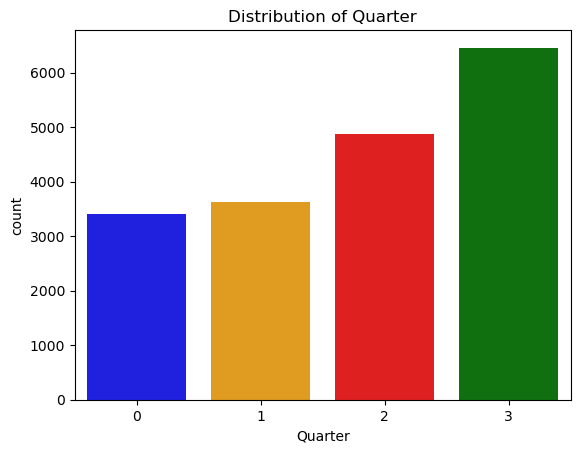

Quarter
4    35.158376
3    26.499401
2    19.772505
1    18.569718
Name: proportion, dtype: float64


In [13]:
# Countplot of Is_UK distribution
sns.countplot(x=df_balanced_uk["Quarter"], palette=["blue", "orange","red","green"])
plt.xticks([0, 1,2,3], ['0',"1", "2",'3'])
plt.title("Distribution of Quarter")
plt.show()

# Print actual counts
print(df_balanced_uk["Quarter"].value_counts(normalize=True) * 100)  # Percentage

Strong Positive Correlations (Good Pairing Options)

    LabelE_StockCode (1.0)

    Period (1.0)

    CustomerID (1.0)

    LabelE_CustomerID (1.0)

    Quarter (1.0)

Strong Negative Correlations

    QuantityLog (-1.0)

    Total_Revenue (-1.0)

    Clustered_Description (-1.0)

Best Pairing Options with Is_UK

Since we need a balanced combination, the best features to pair with Is_UK should provide additional predictive power. Based on correlation:

✅ Is_UK + CountryCategory → Strong predictor of region-based differences.
✅ Is_UK + QuantityLog → Purchase behavior differences are clear.
✅ Is_UK + Total_Revenue → Good for revenue-focused predictions.

## Train, test, validation(unseen)

In [14]:
X = df_balanced_uk.drop("Is_UK", axis=1)  # Features
y = df_balanced_uk["Is_UK"]  # Target

In [15]:
# 1️⃣ Split data into Training (70%), Validation (15%), and Test (15%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

print(f"Training Set: {len(X_train)} samples")
print(f"\nValidation Set: {len(X_val)} samples")
print(f"\nTest Set: {len(X_test)} samples")
print(f"\nClass Distribution Before Resampling: {Counter(y_train)}")

# 2️⃣ Apply SMOTE **only to the training set**
smote = SMOTE(sampling_strategy="auto", random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print(f"\nClass Distribution After Resampling: {Counter(y_train_resampled)}")

Training Set: 12861 samples

Validation Set: 2756 samples

Test Set: 2757 samples

Class Distribution Before Resampling: Counter({1: 6431, 0: 6430})

Class Distribution After Resampling: Counter({1: 6431, 0: 6431})


# MODEL

In [16]:
def best_parameters(model_name, input):
    print(f"Best {model_name} Parameters: {input.best_params_}")

def training_accuracy(model_name, y_test, y_test_pred):
    print(f"{model_name} Training Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")

def validation_accuracy(model_name, y_val, y_val_pred):
    print(f"{model_name} Validation Accuracy: {accuracy_score(y_val, y_val_pred):.4f}")

def test_accuracy(model_name, y_test, y_test_pred):
    print(f"{model_name} Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")

def test_classification_report(model_name, y_test, y_test_pred):
    print(f"{model_name} Classification Report (Test):")
    print(classification_report(y_test, y_test_pred, digits=4, zero_division=1))

def get_confusion_values(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return {"TP": tp, "FP": fp, "TN": tn, "FN": fn}


def confusion_metrics(y_val, y_val_pred, y_test, y_test_pred):
    val_metrics = get_confusion_values(y_val, y_val_pred)
    test_metrics = get_confusion_values(y_test, y_test_pred)
    return val_metrics, test_metrics


def basic_confusion_table(val_metrics, test_metrics):
    table_data = [
        ["True Positives (TP)", val_metrics["TP"], test_metrics["TP"]],
        ["False Positives (FP)", val_metrics["FP"], test_metrics["FP"]],
        ["True Negatives (TN)", val_metrics["TN"], test_metrics["TN"]],
        ["False Negatives (FN)", val_metrics["FN"], test_metrics["FN"]]
    ]
    return table_data
    

def display_basic_confusion_table(model_name, table_data):
    print(f"\n{model_name} Confusion Matrix:")
    print(tabulate(table_data, headers=["Metric", "Validation", "Test"], tablefmt="grid"))


def comparison_confusion_table(m1_name, m2_name, m1_val_metrics, m1_test_metrics, m2_val_metrics, m2_test_metrics):
    table_data = [
        ["True Positives (TP)", m1_val_metrics["TP"], m1_test_metrics["TP"], m2_val_metrics["TP"], m2_test_metrics["TP"]],
        ["False Positives (FP)", m1_val_metrics["FP"], m1_test_metrics["FP"], m2_val_metrics["FP"], m2_test_metrics["FP"]],
        ["True Negatives (TN)", m1_val_metrics["TN"], m1_test_metrics["TN"], m2_val_metrics["TN"], m2_test_metrics["TN"]],
        ["False Negatives (FN)", m1_val_metrics["FN"], m1_test_metrics["FN"], m2_val_metrics["FN"], m2_test_metrics["FN"]]
    ]
    print(tabulate(table_data, headers=["Metric", m1_name+ " (Validation)", m1_name+" (Test)", m2_name+" (Validation)", m2_name+" (Test)"], tablefmt="grid"))


def comparison_df(model1_name, val1, test1, model2_name, val2, test2):
    m1_val_acc = accuracy_score(y_val, val1)
    m1_test_acc = accuracy_score(y_test, test1)
    m2_val_acc = accuracy_score(y_val, val2)
    m2_test_acc = accuracy_score(y_test, test2)
    
    # Create comparison dataframe with formatted strings
    comparison = pd.DataFrame({
        "Metric": ["Validation Accuracy", "Test Accuracy"],
        model1_name: [f"{m1_val_acc:.4f}", f"{m1_test_acc:.4f}"],
        model2_name: [f"{m2_val_acc:.4f}", f"{m2_test_acc:.4f}"]
    })
    print(f"\n Comparison of {model1_name} & {model2_name} : \n{comparison}")


def comparison_accuracy_table(model1_name, val1, test1, model2_name, val2, test2):
    m1_val_acc = accuracy_score(y_val, val1)
    m1_test_acc = accuracy_score(y_test, test1)
    m2_val_acc = accuracy_score(y_val, val2)
    m2_test_acc = accuracy_score(y_test, test2)
    
    table_data = [
        ["Validation Accuracy", f"{m1_val_acc:.4f}", f"{m2_val_acc:.4f}"],
        ["Test Accuracy", f"{m1_test_acc:.4f}", f"{m2_test_acc:.4f}"],
    ]
    print(tabulate(table_data, headers=["Metric", model1_name, model2_name], tablefmt="grid"))

    ✅ Accuracy Score – Percentage of correct predictions.
    ✅ Precision – How many positive predictions were actually correct.
    ✅ Recall (Sensitivity) – How many actual positives were correctly identified.
    ✅ F1-Score – Balances precision & recall for overall performance.
    ✅ Support – Number of actual occurrences of each class.

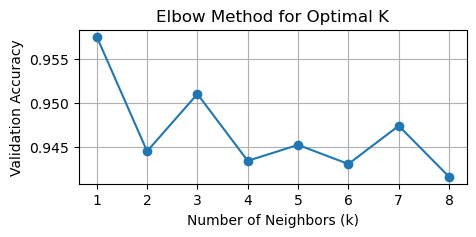

In [17]:
# Try different k values
k_values = range(1, 9)
accuracies = []

for k in k_values:
    knn_elbow = KNeighborsClassifier(n_neighbors=k)
    knn_elbow.fit(X_train_resampled, y_train_resampled)
    y_val_pred = knn_elbow.predict(X_val)
    accuracies.append(accuracy_score(y_val, y_val_pred))
    

# Plot the elbow graph
plt.figure(figsize=(5, 2))
plt.plot(k_values, accuracies, marker='o')
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Validation Accuracy")
plt.title("Elbow Method for Optimal K")
plt.xticks(k_values)
plt.grid()
plt.show()

In [18]:
# Train KNN Model
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(X_train_resampled, y_train_resampled)

# Predictions
knn_y_val_pred = knn_model.predict(X_val)

# Evaluation
knn_y_test_pred = knn_model.predict(X_test)

In [19]:
model_name = "KNN"
validation_accuracy(model_name, y_val, knn_y_val_pred)
test_accuracy(model_name, y_test, knn_y_test_pred)
test_classification_report(model_name, y_test, knn_y_test_pred)

# Get confusion values(Validation & Test)
knn_val_metrics, knn_test_metrics = confusion_metrics(y_val, knn_y_val_pred, y_test, knn_y_test_pred)
knn_table = basic_confusion_table(knn_val_metrics, knn_test_metrics)
display_basic_confusion_table(model_name, knn_table)

KNN Validation Accuracy: 0.9510
KNN Test Accuracy: 0.9565
KNN Classification Report (Test):
              precision    recall  f1-score   support

           0     0.9442    0.9703    0.9571      1379
           1     0.9694    0.9427    0.9558      1378

    accuracy                         0.9565      2757
   macro avg     0.9568    0.9565    0.9565      2757
weighted avg     0.9568    0.9565    0.9565      2757


KNN Confusion Matrix:
+----------------------+--------------+--------+
| Metric               |   Validation |   Test |
+======================+==============+========+
| True Positives (TP)  |         1296 |   1299 |
+----------------------+--------------+--------+
| False Positives (FP) |           53 |     41 |
+----------------------+--------------+--------+
| True Negatives (TN)  |         1325 |   1338 |
+----------------------+--------------+--------+
| False Negatives (FN) |           82 |     79 |
+----------------------+--------------+--------+


In [20]:
# Hyperparameter tuning for KNN
param_grid_knn = {
    'n_neighbors': [1, 3, 5, 7, 9],  # Test different values for n_neighbors
    'weights': ['uniform', 'distance'],  # Try both uniform and distance-based weighting
    'metric': ['euclidean', 'manhattan', 'minkowski']  # Different distance metrics
}

# Initialize KNN model
ht_knn = KNeighborsClassifier()

# Perform grid search with cross-validation (cv=5)
grid_search_knn = GridSearchCV(estimator=ht_knn, param_grid=param_grid_knn, cv=3, n_jobs=-1, verbose=1, scoring='f1_macro')
grid_search_knn.fit(X_train_resampled, y_train_resampled)

# Get the best model from the grid search
best_knn = grid_search_knn.best_estimator_

# Predictions and Evaluation on validation set
ht_knn_y_val_pred = best_knn.predict(X_val)

# Evaluation on test set
ht_knn_y_test_pred = best_knn.predict(X_test)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


In [21]:
model_name = "HyperTunned KNN"
best_parameters(model_name, grid_search_knn)
validation_accuracy(model_name, y_val, ht_knn_y_val_pred)
test_accuracy(model_name, y_test, ht_knn_y_test_pred)
test_classification_report(model_name, y_test, ht_knn_y_test_pred)

# Get confusion values(Validation & Test)
ht_knn_val_metrics, ht_knn_test_metrics = confusion_metrics(y_val, ht_knn_y_val_pred, y_test, ht_knn_y_test_pred)
ht_knn_table = basic_confusion_table(ht_knn_val_metrics, ht_knn_test_metrics)
display_basic_confusion_table(model_name, ht_knn_table)

comparison_df("KNN", knn_y_val_pred, knn_y_test_pred, 
             "HyperTuned KNN", ht_knn_y_val_pred, ht_knn_y_test_pred)

Best HyperTunned KNN Parameters: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}
HyperTunned KNN Validation Accuracy: 0.9579
HyperTunned KNN Test Accuracy: 0.9641
HyperTunned KNN Classification Report (Test):
              precision    recall  f1-score   support

           0     0.9533    0.9761    0.9645      1379
           1     0.9755    0.9521    0.9636      1378

    accuracy                         0.9641      2757
   macro avg     0.9644    0.9641    0.9641      2757
weighted avg     0.9644    0.9641    0.9641      2757


HyperTunned KNN Confusion Matrix:
+----------------------+--------------+--------+
| Metric               |   Validation |   Test |
+======================+==============+========+
| True Positives (TP)  |         1294 |   1312 |
+----------------------+--------------+--------+
| False Positives (FP) |           32 |     33 |
+----------------------+--------------+--------+
| True Negatives (TN)  |         1346 |   1346 |
+-------------------

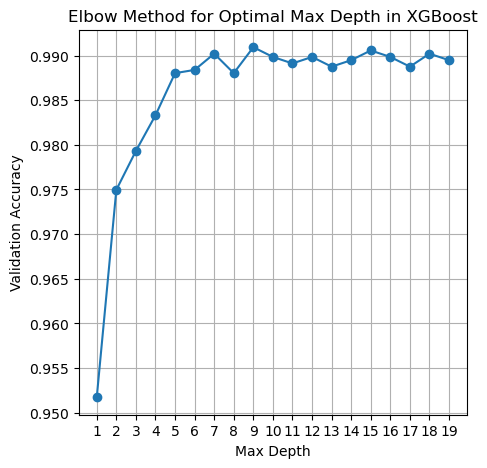

In [22]:
# Range of max_depth values to test
max_depth_values = list(range(1, 20))
val_accuracies = []

for depth in max_depth_values:
    xgb_elbow = XGBClassifier(max_depth=depth, eval_metric='mlogloss')
    xgb_elbow.fit(X_train_resampled, y_train_resampled)
    
    # Predictions on validation set
    y_val_pred = xgb_elbow.predict(X_val)
    
    # Calculate accuracy
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_accuracies.append(val_accuracy)

# Plot Elbow Graph
plt.figure(figsize=(5, 5))
plt.plot(max_depth_values, val_accuracies, marker='o')
plt.xlabel('Max Depth')
plt.ylabel('Validation Accuracy')
plt.title('Elbow Method for Optimal Max Depth in XGBoost')
plt.xticks(max_depth_values)
plt.grid(True)
plt.show()

In [23]:
# Train XGBoost Model
xgb_model = XGBClassifier(max_depth=15, eval_metric='mlogloss')
xgb_model.fit(X_train_resampled, y_train_resampled)

# Predictions
xgb_y_val_pred = xgb_model.predict(X_val)

# Evaluation
xgb_y_test_pred = xgb_model.predict(X_test)

In [24]:
model_name = "XGB"
validation_accuracy(model_name, y_val, xgb_y_val_pred)
test_accuracy(model_name, y_test, xgb_y_test_pred)
test_classification_report(model_name, y_test, xgb_y_test_pred)

# Get confusion values(Validation & Test)
xgb_val_metrics, xgb_test_metrics = confusion_metrics(y_val, xgb_y_val_pred, y_test, xgb_y_test_pred)
xgb_table = basic_confusion_table(xgb_val_metrics, xgb_test_metrics)
display_basic_confusion_table(model_name, xgb_table)

XGB Validation Accuracy: 0.9906
XGB Test Accuracy: 0.9891
XGB Classification Report (Test):
              precision    recall  f1-score   support

           0     0.9913    0.9869    0.9891      1379
           1     0.9870    0.9913    0.9891      1378

    accuracy                         0.9891      2757
   macro avg     0.9891    0.9891    0.9891      2757
weighted avg     0.9891    0.9891    0.9891      2757


XGB Confusion Matrix:
+----------------------+--------------+--------+
| Metric               |   Validation |   Test |
+======================+==============+========+
| True Positives (TP)  |         1362 |   1366 |
+----------------------+--------------+--------+
| False Positives (FP) |           10 |     18 |
+----------------------+--------------+--------+
| True Negatives (TN)  |         1368 |   1361 |
+----------------------+--------------+--------+
| False Negatives (FN) |           16 |     12 |
+----------------------+--------------+--------+


In [25]:
# Hyperparameter tuning for XGBoost
param_grid_xgb = {
    'max_depth': [3, 5, 7, 9],  # Test different values for max_depth
    'learning_rate': [0.1, 0.2],  # Try different learning rates
    'n_estimators': [100, 200],  # Number of trees (boosting rounds)
    'subsample': [0.8, 1.0],  # Subsample ratio for training
    'colsample_bytree': [0.8, 1.0],  # Fraction of features for each tree
    'gamma': [0, 0.1]  # Added important regularization parameter
}

# Initialize XGBoost model
ht_xgb = XGBClassifier(eval_metric='mlogloss', n_jobs=-1)

# Perform grid search with cross-validation (cv=5)
grid_search_xgb = GridSearchCV(estimator=ht_xgb, param_grid=param_grid_xgb, cv=3, n_jobs=-1, verbose=1)
grid_search_xgb.fit(X_train_resampled, y_train_resampled, verbose=True)

# Get the best model from the grid search
best_xgb = grid_search_xgb.best_estimator_

# Predictions and Evaluation on validation set
ht_xgb_y_val_pred = best_xgb.predict(X_val)

# Evaluation on test set
ht_xgb_y_test_pred = best_xgb.predict(X_test)

Fitting 3 folds for each of 128 candidates, totalling 384 fits


In [26]:
model_name = "HyperTunned XGB"
best_parameters(model_name, grid_search_knn)
validation_accuracy(model_name, y_val, ht_xgb_y_val_pred)
test_accuracy(model_name, y_test, ht_xgb_y_test_pred)
test_classification_report(model_name, y_test, ht_xgb_y_test_pred)

# Get confusion values(Validation & Test)
ht_xgb_val_metrics, ht_xgb_test_metrics = confusion_metrics(y_val, ht_xgb_y_val_pred, y_test, ht_xgb_y_test_pred)
ht_xgb_table = basic_confusion_table(ht_xgb_val_metrics, ht_xgb_test_metrics)
display_basic_confusion_table(model_name, ht_xgb_table)

comparison_df("XGB", xgb_y_val_pred, xgb_y_test_pred, 
             "HyperTuned XGB", ht_xgb_y_val_pred, ht_xgb_y_test_pred)

Best HyperTunned XGB Parameters: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}
HyperTunned XGB Validation Accuracy: 0.9895
HyperTunned XGB Test Accuracy: 0.9866
HyperTunned XGB Classification Report (Test):
              precision    recall  f1-score   support

           0     0.9862    0.9869    0.9866      1379
           1     0.9869    0.9862    0.9866      1378

    accuracy                         0.9866      2757
   macro avg     0.9866    0.9866    0.9866      2757
weighted avg     0.9866    0.9866    0.9866      2757


HyperTunned XGB Confusion Matrix:
+----------------------+--------------+--------+
| Metric               |   Validation |   Test |
+======================+==============+========+
| True Positives (TP)  |         1362 |   1359 |
+----------------------+--------------+--------+
| False Positives (FP) |           13 |     18 |
+----------------------+--------------+--------+
| True Negatives (TN)  |         1365 |   1361 |
+-------------------

In [27]:
# choosen best out of the 2 models & compare between them
comparison_confusion_table("HyperTunned KNN", "HyperTunned XGB", ht_knn_val_metrics, ht_knn_test_metrics, ht_xgb_val_metrics, ht_xgb_test_metrics)

+----------------------+--------------------------------+--------------------------+--------------------------------+--------------------------+
| Metric               |   HyperTunned KNN (Validation) |   HyperTunned KNN (Test) |   HyperTunned XGB (Validation) |   HyperTunned XGB (Test) |
+======================+================================+==========================+================================+==========================+
| True Positives (TP)  |                           1294 |                     1312 |                           1362 |                     1359 |
+----------------------+--------------------------------+--------------------------+--------------------------------+--------------------------+
| False Positives (FP) |                             32 |                       33 |                             13 |                       18 |
+----------------------+--------------------------------+--------------------------+--------------------------------+-------------

In [28]:
comparison_accuracy_table("HyperTunned KNN", ht_knn_y_val_pred, ht_knn_y_test_pred, 
             "HyperTuned XGB", ht_xgb_y_val_pred, ht_xgb_y_test_pred)

+---------------------+-------------------+------------------+
| Metric              |   HyperTunned KNN |   HyperTuned XGB |
+=====================+===================+==================+
| Validation Accuracy |            0.9579 |           0.9895 |
+---------------------+-------------------+------------------+
| Test Accuracy       |            0.9641 |           0.9866 |
+---------------------+-------------------+------------------+


In [29]:
ht_knn.fit(X_train_resampled, y_train_resampled)
ht_xgb.fit(X_train_resampled, y_train_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=-1, num_parallel_tree=None, random_state=None, ...)

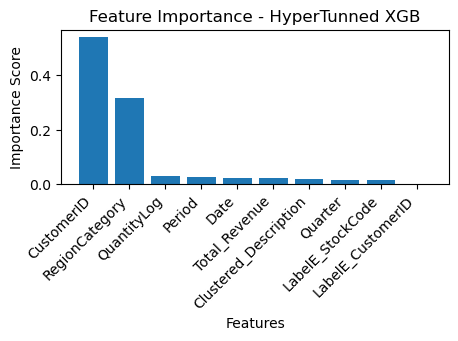

In [30]:
# 1️⃣ Bar Chart - Feature Importance for KNN & XGB
def plot_feature_importance(model, feature_names, model_name):
    importance = model.feature_importances_
    indices = np.argsort(importance)[::-1]  # Sort in descending order

    plt.figure(figsize=(5, 2))
    plt.bar(range(len(importance)), importance[indices], align="center")
    plt.xticks(range(len(importance)), np.array(feature_names)[indices], rotation=45, ha="right")
    plt.xlabel("Features")
    plt.ylabel("Importance Score")
    plt.title(f"Feature Importance - {model_name}")
    plt.show()

plot_feature_importance(ht_xgb, X.columns, "HyperTunned XGB")

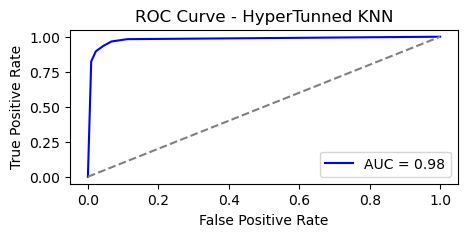

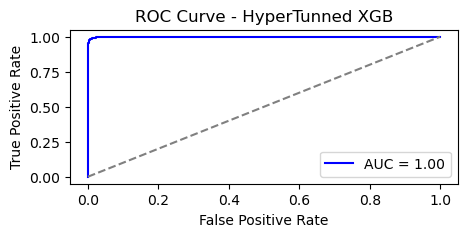

In [31]:
# 2️⃣ ROC Curve - Model Performance
def plot_roc_curve(model, X_val, y_val, model_name):
    y_probs = model.predict_proba(X_val)[:, 1]  # Get probability scores
    fpr, tpr, _ = roc_curve(y_val, y_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(5, 2))
    plt.plot(fpr, tpr, color="blue", label=f"AUC = {roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Baseline
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {model_name}")
    plt.legend()
    plt.show()

plot_roc_curve(ht_knn, X_val, y_val, "HyperTunned KNN")
plot_roc_curve(ht_xgb, X_val, y_val, "HyperTunned XGB")

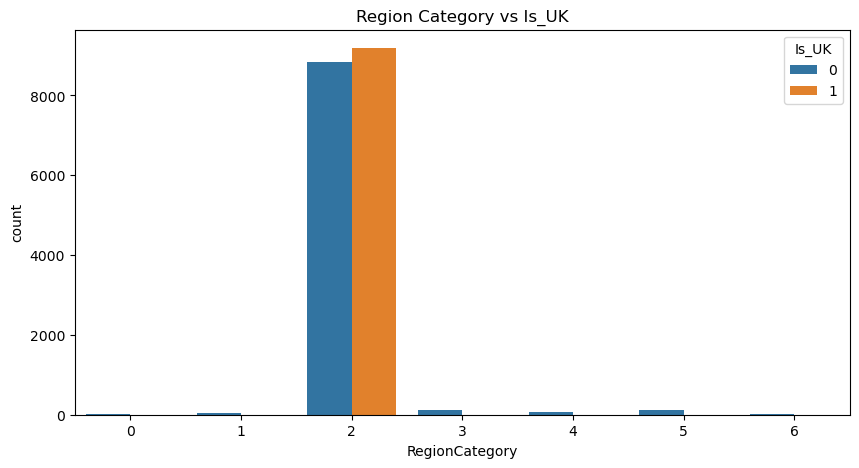

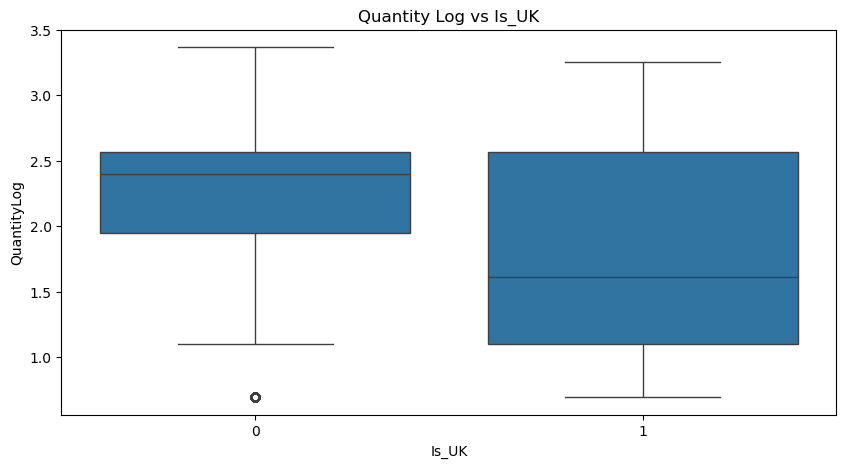

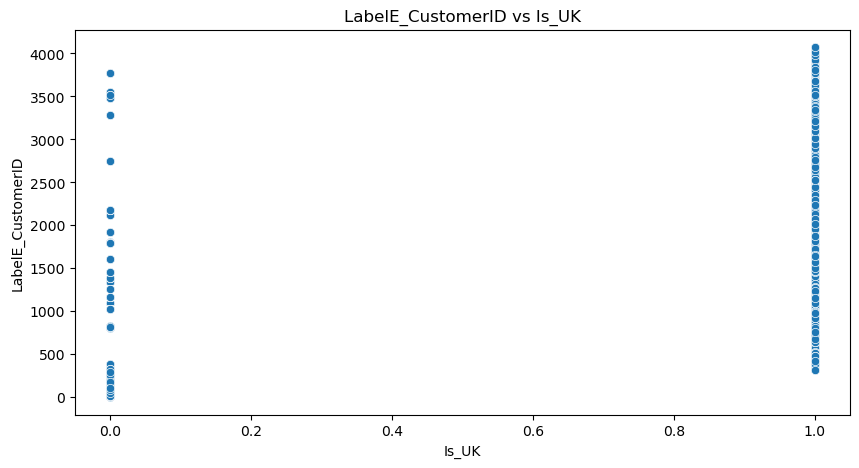

In [36]:
# 1. Bar chart for regioncategory and Is_UK
plt.figure(figsize=(10, 5))
sns.countplot(x='RegionCategory', hue='Is_UK', data=df_balanced_uk) 
plt.title("Region Category vs Is_UK")
plt.show()

# 2. Box plot for quantitylog and Is_UK
plt.figure(figsize=(10, 5))
sns.boxplot(x='Is_UK', y='QuantityLog', data=df_balanced_uk)
plt.title("Quantity Log vs Is_UK")
plt.show()

# 3. Scatter plot for customerID (this might not be as informative)
# You can visualize customerID vs Is_UK, but it may be more useful to aggregate it.
plt.figure(figsize=(10, 5))
sns.scatterplot(x='Is_UK', y='LabelE_CustomerID', data=df_balanced_uk)
plt.title("LabelE_CustomerID vs Is_UK")
plt.show()

In [37]:
# Scale the features (important for neural networks)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

(2757, 10) (2757,)


In [50]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Define the Neural Network model
model = Sequential()

# Input layer and the first hidden layer (with ReLU activation)
model.add(Dense(units=64, activation='relu', input_dim=X_train_scaled.shape[1]))

# Hidden layers
model.add(Dense(units=128, activation='relu'))  # First additional hidden layer
model.add(Dense(units=64, activation='relu'))   # Second additional hidden layer
model.add(Dense(units=32, activation='relu'))   # Third additional hidden layer
model.add(Dense(units=16, activation='relu'))   # Fourth additional hidden layer

# Output layer (sigmoid activation for binary classification)
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Metric to monitor (val_loss, val_accuracy, etc.)
    patience=4,             # Number of epochs to wait before stopping
    restore_best_weights=True  # Keeps the best model weights
)

# Train the model
history = model.fit(
    X_train_scaled, 
    y_train_resampled, 
    epochs=50, 
    batch_size=32, 
    validation_data=(X_test_scaled, y_test),
    callbacks=[early_stopping]
)


# Evaluate the model
test_loss, test_acc = model.evaluate(X_test_scaled, y_test)
print(f"Test accuracy: {test_acc}")

# You can also make predictions
y_pred = (model.predict(X_test_scaled) > 0.5).astype("int32")  # 0.5 threshold for binary classification

# You can then evaluate performance like accuracy, confusion matrix, classification report, etc.
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Epoch 1/50
402/402 [==============================] - 3s 4ms/step - loss: 0.3562 - accuracy: 0.8196 - val_loss: 0.2909 - val_accuracy: 0.8585
Epoch 2/50
402/402 [==============================] - 1s 3ms/step - loss: 0.2621 - accuracy: 0.8829 - val_loss: 0.2385 - val_accuracy: 0.8959
Epoch 3/50
402/402 [==============================] - 2s 4ms/step - loss: 0.2216 - accuracy: 0.9090 - val_loss: 0.2079 - val_accuracy: 0.9159
Epoch 4/50
402/402 [==============================] - 1s 3ms/step - loss: 0.2036 - accuracy: 0.9167 - val_loss: 0.1953 - val_accuracy: 0.9151
Epoch 5/50
402/402 [==============================] - 1s 3ms/step - loss: 0.1904 - accuracy: 0.9231 - val_loss: 0.1948 - val_accuracy: 0.9220
Epoch 6/50
402/402 [==============================] - 1s 3ms/step - loss: 0.1797 - accuracy: 0.9253 - val_loss: 0.1853 - val_accuracy: 0.9217
Epoch 7/50
402/402 [==============================] - 1s 3ms/step - loss: 0.1718 - accuracy: 0.9307 - val_loss: 0.1726 - val_accuracy: 0.9354
Epoch 

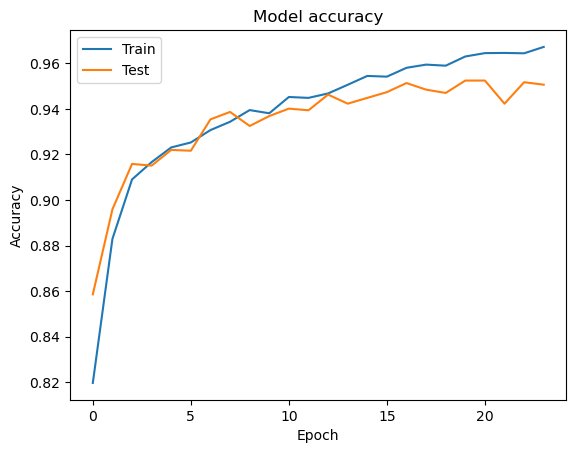

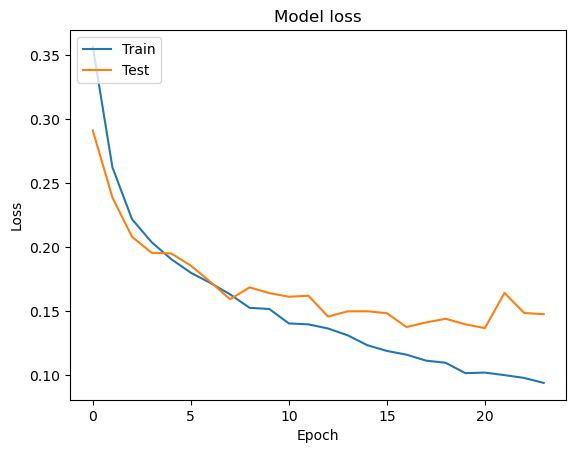

In [51]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()